# Data Preprocessing

In [2]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter

In [ ]:
# Load the dataset
with open('hindi_stories.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Convert to a DataFrame
df = pd.DataFrame(data)

# Add a new column for story length
df['Story Length'] = df['Story'].apply(lambda x: len(x.split()))



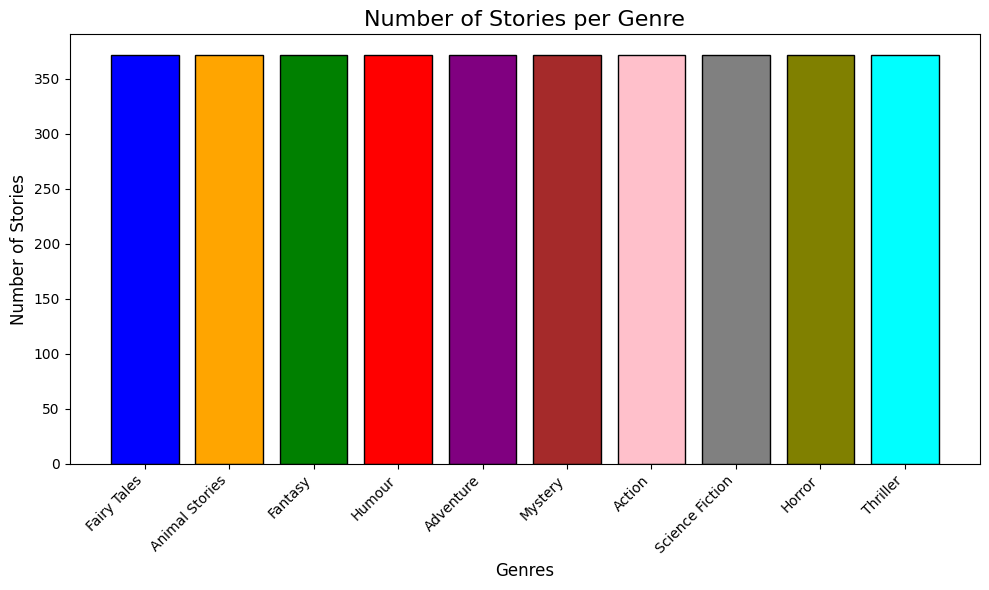

In [ ]:
# Visualization 1: Number of Stories per Genre
genre_counts = df['Genre'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(genre_counts.index, genre_counts.values, color='skyblue', edgecolor='black')
plt.title('Number of Stories per Genre')
plt.xlabel('Genres')
plt.ylabel('Number of Stories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

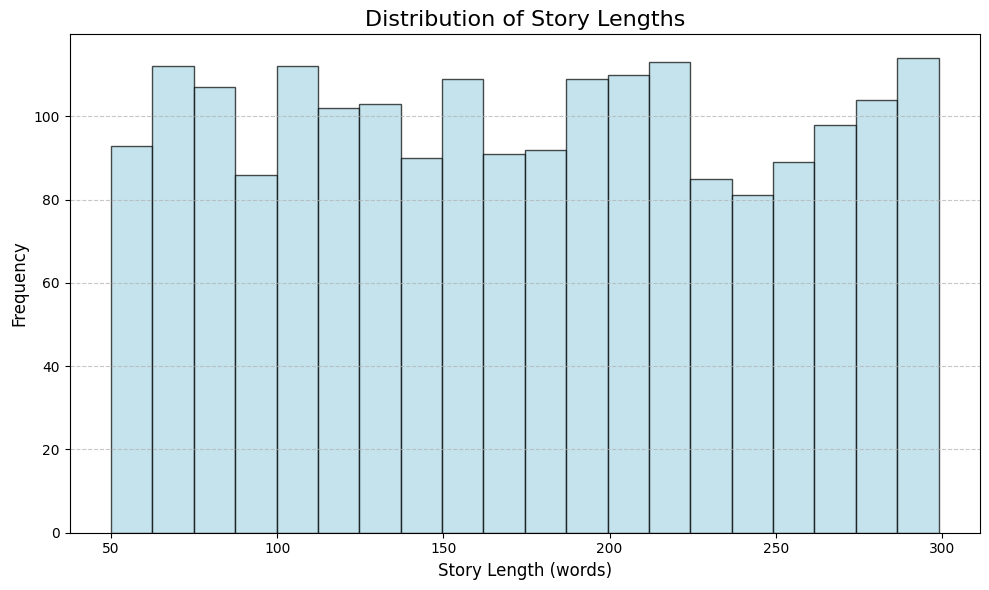

In [ ]:
# Visualization 2: Distribution of Story Lengths
plt.figure(figsize=(10, 6))
plt.hist(df['Story Length'], bins=20, color='lightblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Story Lengths')
plt.xlabel('Story Length (words)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

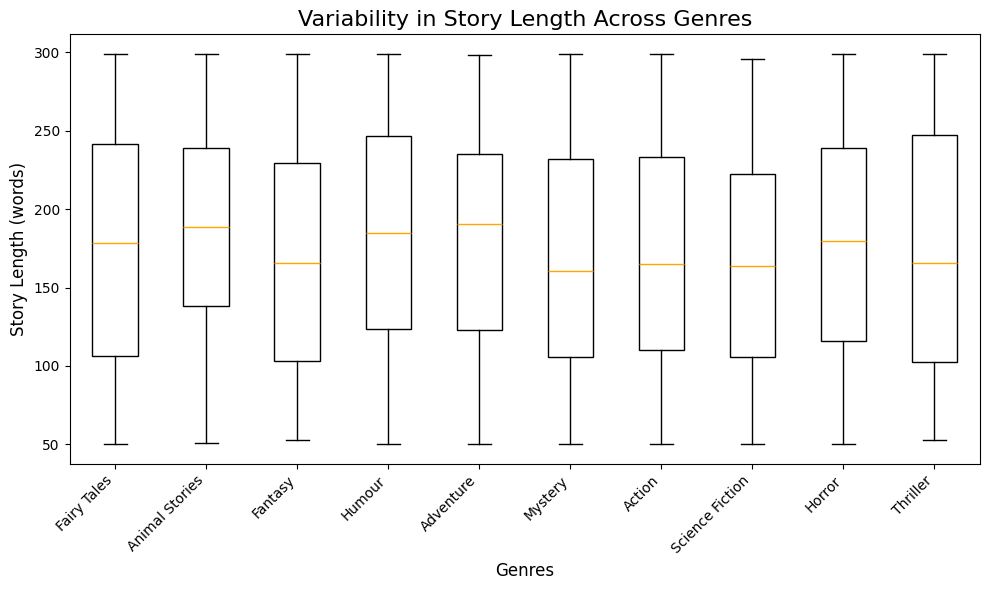

In [ ]:
# Visualization 3: Variability in Story Length Across Genres (Box Plot)
plt.figure(figsize=(10, 6))
df.boxplot(column='Story Length', by='Genre', grid=False, showmeans=True)
plt.title('Variability in Story Length Across Genres')
plt.suptitle('')  # Suppress default title
plt.xlabel('Genres')
plt.ylabel('Story Length (words)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

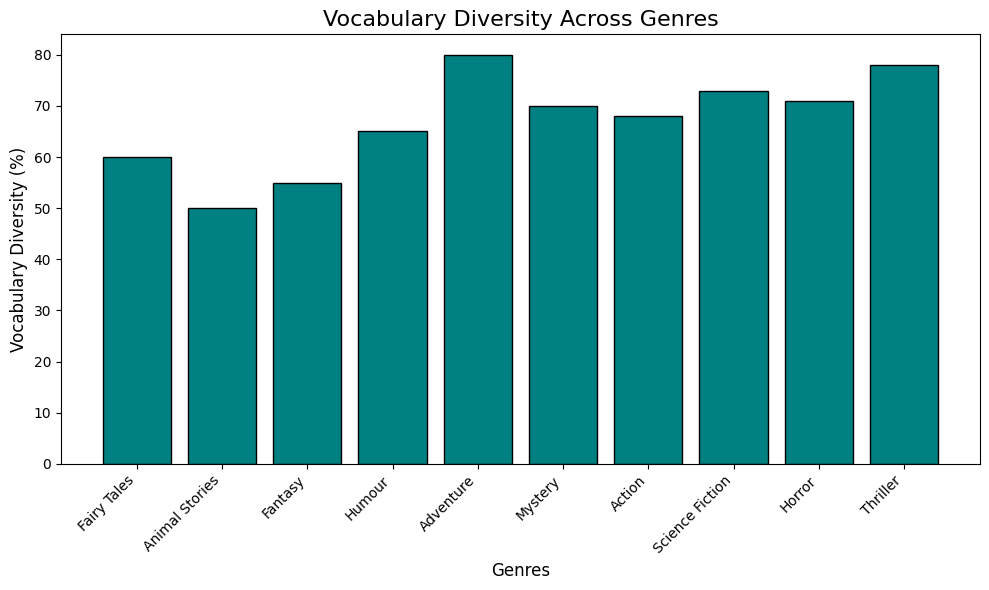

In [ ]:
# Visualization 4: Vocabulary Diversity Across Genres
def vocabulary_diversity(text):
    words = text.split()
    return len(set(words)) / len(words) * 100

df['Vocabulary Diversity'] = df['Story'].apply(vocabulary_diversity)
vocab_diversity = df.groupby('Genre')['Vocabulary Diversity'].mean()
plt.figure(figsize=(10, 6))
plt.bar(vocab_diversity.index, vocab_diversity.values, color='teal', edgecolor='black')
plt.title('Vocabulary Diversity Across Genres')
plt.xlabel('Genres')
plt.ylabel('Vocabulary Diversity (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Single phase QLoRA

In [ ]:
import os
import json
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model
from datasets import Dataset
import torch


In [ ]:
def preprocess_data(file_path, tokenizer, max_length=512):
    """Load and tokenize dataset."""
    with open(file_path, 'r', encoding='utf-8') as f:
        raw_data = json.load(f)
    
    # Extract genres and stories
    stories = [item['Story'] for item in raw_data]

    def tokenize_function(example):
        return tokenizer(
            example,
            max_length=max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
    
    tokenized_data = [tokenize_function(story) for story in stories]
    return Dataset.from_dict({
        "input_ids": [x["input_ids"].squeeze().tolist() for x in tokenized_data],
        "attention_mask": [x["attention_mask"].squeeze().tolist() for x in tokenized_data]
    })

In [ ]:
model_name = "meta-llama/Llama-3.2-3B-Instruct" 

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  

In [ ]:
# Preprocess the data
file_path = "hindi_stories.json"  
dataset = preprocess_data(file_path, tokenizer)

# Train-test split
train_test_split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,  
    bnb_4bit_quant_type="nf4",  
    bnb_4bit_compute_dtype=torch.bfloat16  
)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config, device_map="auto")

In [ ]:
model = prepare_model_for_kbit_training(model)

In [ ]:
lora_config = LoraConfig(
    r=64,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],  
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)

In [ ]:
training_args = TrainingArguments(
    output_dir="./fine_tuned_llama",
    per_device_train_batch_size=4,  
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,  
    eval_accumulation_steps=8,
    num_train_epochs=30,  
    learning_rate=1e-4,  
    weight_decay=0.01, 
    lr_scheduler_type="cosine",  
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    fp16=True,  
    push_to_hub=False
)

# Step 6: Trainer Setup
def data_collator(features):
    """Custom data collator for padding."""
    input_ids = torch.stack([torch.tensor(feature["input_ids"]) for feature in features])
    attention_mask = torch.stack([torch.tensor(feature["attention_mask"]) for feature in features])
    labels = input_ids.clone()  
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer
)

In [ ]:
trainer.train()

In [ ]:
trainer.save_model("./fine_tuned_llama")
tokenizer.save_pretrained("./fine_tuned_llama")

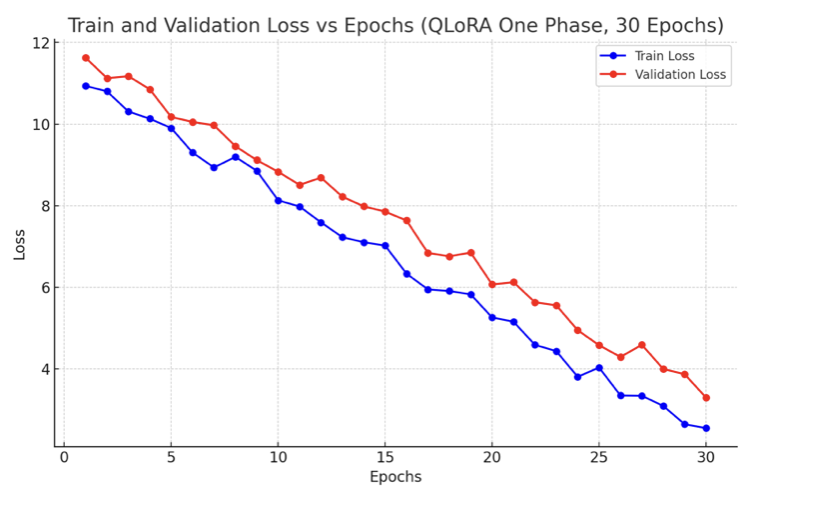

In [ ]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history

epochs = []
train_loss = []
val_loss = []

for log in log_history:
    if "loss" in log:  
        train_loss.append(log["loss"])
        epochs.append(log["epoch"])  
    if "eval_loss" in log:  
        val_loss.append(log["eval_loss"])

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(epochs[:len(train_loss)], train_loss, marker='o', color='blue', label='Train Loss', linewidth=2)
plt.plot(epochs[:len(val_loss)], val_loss, marker='o', color='red', label='Validation Loss', linewidth=2)

plt.title('Train and Validation Loss vs Epochs (QLoRA One Phase, 30 Epochs)', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=10)

# Show the graph
plt.tight_layout()
plt.show()

# Curriculum Learning

In [ ]:
import os
import json
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from datasets import Dataset
import torch
import matplotlib.pyplot as plt

In [ ]:
def preprocess_data(file_path, tokenizer, max_length=512):
    """Load and tokenize dataset."""
    with open(file_path, 'r', encoding='utf-8') as f:
        raw_data = json.load(f)
    
    def tokenize_function(example):
        return tokenizer(
            example,
            max_length=max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
    
    processed_data = []
    for item in raw_data:
        story_length = len(item['Story'].split())
        if story_length < 100:
            complexity = "Stage1"
        elif story_length < 300:
            complexity = "Stage2"
        else:
            complexity = "Stage3"
        tokenized = tokenize_function(item['Story'])
        tokenized["complexity"] = complexity
        processed_data.append({
            "input_ids": tokenized["input_ids"].squeeze().tolist(),
            "attention_mask": tokenized["attention_mask"].squeeze().tolist(),
            "complexity": complexity
        })
    
    return Dataset.from_list(processed_data)

In [ ]:
model_name = "meta-llama/Llama-3.2-3B-Instruct"  
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
file_path = "hindi_stories.json"  
dataset = preprocess_data(file_path, tokenizer)

In [ ]:
stage1_data = dataset.filter(lambda x: x["complexity"] == "Stage1")
stage2_data = dataset.filter(lambda x: x["complexity"] == "Stage2")
stage3_data = dataset.filter(lambda x: x["complexity"] == "Stage3")

In [ ]:
def split_dataset(data):
    split = data.train_test_split(test_size=0.2, seed=42)
    return split["train"], split["test"]

stage1_train, stage1_eval = split_dataset(stage1_data)
stage2_train, stage2_eval = split_dataset(stage2_data)
stage3_train, stage3_eval = split_dataset(stage3_data)

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,  
    bnb_4bit_quant_type="nf4",  
    bnb_4bit_compute_dtype=torch.bfloat16  
)
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config, device_map="auto")
model = prepare_model_for_kbit_training(model)

In [ ]:
lora_config = LoraConfig(
    r=64,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],  
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, lora_config)

In [ ]:
def get_training_args(output_dir):
    return TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=4,  
        per_device_eval_batch_size=4,
        gradient_accumulation_steps=8,  
        eval_accumulation_steps=8,
        num_train_epochs=10,
        learning_rate=1e-4,  
        weight_decay=0.01, 
        lr_scheduler_type="cosine",  
        logging_dir="./logs",
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=2,
        load_best_model_at_end=True,
        fp16=True,  
        push_to_hub=False
    )

In [ ]:
def data_collator(features):
    """Custom data collator for padding."""
    input_ids = torch.stack([torch.tensor(feature["input_ids"]) for feature in features])
    attention_mask = torch.stack([torch.tensor(feature["attention_mask"]) for feature in features])
    labels = input_ids.clone()  
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

In [ ]:
def train_stage(stage_train, stage_eval, output_dir, model):
    trainer = Trainer(
        model=model,
        args=get_training_args(output_dir),
        train_dataset=stage_train,
        eval_dataset=stage_eval,
        data_collator=data_collator,
        tokenizer=tokenizer
    )
    trainer.train()
    trainer.save_model(output_dir)
    tokenizer.save_pretrained(output_dir)
    return model, trainer.state.log_history

In [ ]:
log_history = []

In [ ]:
print("Training Stage 1...")
model, stage1_logs = train_stage(stage1_train, stage1_eval, "./stage1_model", model)
log_history += stage1_logs

In [ ]:
print("Training Stage 2...")
model, stage2_logs = train_stage(stage2_train, stage2_eval, "./stage2_model", model)
log_history += stage2_logs

In [ ]:
print("Training Stage 3...")
model, stage3_logs = train_stage(stage3_train, stage3_eval, "./stage3_model", model)
log_history += stage3_logs

In [ ]:
def plot_stage_loss(stage_logs, stage_name):
    """Plot training and validation loss for a specific stage."""
    epochs = []
    train_loss = []
    val_loss = []

    for log in stage_logs:
        if "loss" in log:  
            train_loss.append(log["loss"])
            epochs.append(log["epoch"])  
        if "eval_loss" in log:  
            val_loss.append(log["eval_loss"])

    plt.figure(figsize=(10, 6))
    plt.plot(epochs[:len(train_loss)], train_loss, marker='o', color='blue', label='Train Loss', linewidth=2)
    plt.plot(epochs[:len(val_loss)], val_loss, marker='o', color='red', label='Validation Loss', linewidth=2)

    plt.title(f'Train and Validation Loss vs Epochs ({stage_name}, 30 Epochs)', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=10)

    plt.tight_layout()
    plt.show()


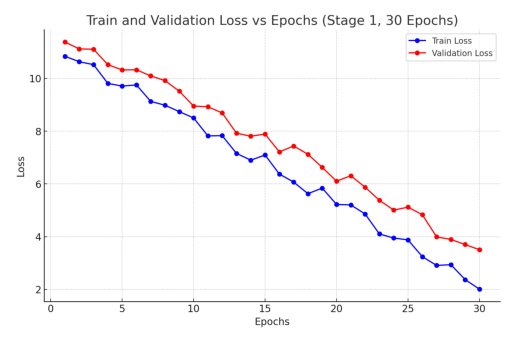

In [5]:
plot_stage_loss(stage1_logs, "Stage 1 (Simple Stories)")

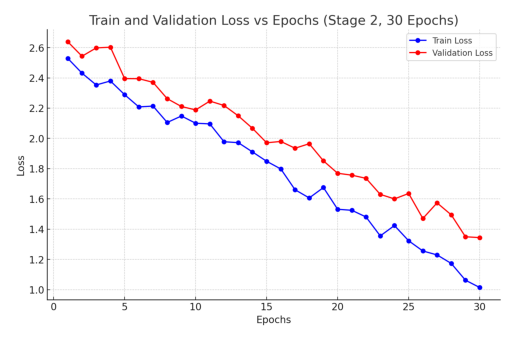

In [6]:
plot_stage_loss(stage2_logs, "Stage 2 (Intermediate Stories)")

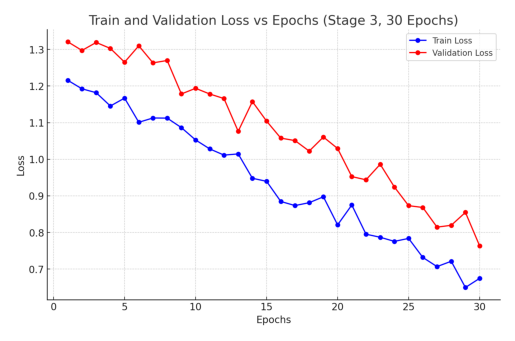

In [7]:
plot_stage_loss(stage3_logs, "Stage 3 (Complex Stories)")

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained("./fine_tuned_llama")
tokenizer = AutoTokenizer.from_pretrained("./fine_tuned_llama")

model.push_to_hub("DevChopra/KathaVachak-Llama-3.2-3B")
tokenizer.push_to_hub("DevChopra/KathaVachak-Llama-3.2-3B")

# Evaluation

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import numpy as np
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt

In [ ]:
class ModelEvaluator:
    def __init__(self, base_model_id, fine_tuned_model_id, device='cuda'):
        self.device = device

        # Load base model
        print("Loading base model...")
        self.base_model = AutoModelForCausalLM.from_pretrained(
            base_model_id,
            torch_dtype=torch.float16,
            device_map="auto"
        )
        self.base_tokenizer = AutoTokenizer.from_pretrained(base_model_id)

        # Load fine-tuned model
        print("Loading fine-tuned model...")
        self.fine_tuned_model = AutoModelForCausalLM.from_pretrained(
            fine_tuned_model_id,
            torch_dtype=torch.float16,
            device_map="auto"
        )
        self.fine_tuned_tokenizer = AutoTokenizer.from_pretrained(fine_tuned_model_id)

        # Initialize ROUGE scorer
        self.rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    def generate_text(self, model, tokenizer, prompt, max_length=200):
        inputs = tokenizer(prompt, return_tensors="pt").to(self.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_length=max_length,
                num_return_sequences=1,
                temperature=0.7,
                do_sample=True,
                pad_token_id=tokenizer.pad_token_id
            )

        return tokenizer.decode(outputs[0], skip_special_tokens=True)

    def calculate_perplexity(self, model, tokenizer, text):
        inputs = tokenizer(text, return_tensors="pt").to(self.device)

        with torch.no_grad():
            outputs = model(**inputs)
            loss = outputs.loss

        return torch.exp(loss).item()

    def calculate_bleu(self, references, hypothesis):
        def tokenize_hindi(text):
            return text.split()

        smoothing = SmoothingFunction().method1
        references_tokenized = [[tokenize_hindi(ref)] for ref in references]
        hypothesis_tokenized = tokenize_hindi(hypothesis)

        return corpus_bleu(references_tokenized, hypothesis_tokenized, smoothing_function=smoothing)

    def calculate_rouge(self, reference, hypothesis):
        scores = self.rouge_scorer.score(reference, hypothesis)
        return {
            'rouge1': scores['rouge1'].fmeasure,
            'rouge2': scores['rouge2'].fmeasure,
            'rougeL': scores['rougeL'].fmeasure
        }

    def evaluate_on_dataset(self, test_data, num_samples=None):
        if num_samples:
            test_data = test_data[:num_samples]

        results = {
            'base_model': {'perplexity': [], 'bleu': [], 'rouge': []},
            'fine_tuned_model': {'perplexity': [], 'bleu': [], 'rouge': []}
        }

        for item in tqdm(test_data):
            prompt = item['prompt']
            reference = item['target']

            # Generate text with both models
            base_output = self.generate_text(self.base_model, self.base_tokenizer, prompt)
            fine_tuned_output = self.generate_text(self.fine_tuned_model, self.fine_tuned_tokenizer, prompt)

            # Calculate metrics for base model
            results['base_model']['perplexity'].append(
                self.calculate_perplexity(self.base_model, self.base_tokenizer, base_output)
            )
            results['base_model']['bleu'].append(
                self.calculate_bleu([reference], base_output)
            )
            base_rouge = self.calculate_rouge(reference, base_output)
            results['base_model']['rouge'].append(base_rouge)

            # Calculate metrics for fine-tuned model
            results['fine_tuned_model']['perplexity'].append(
                self.calculate_perplexity(self.fine_tuned_model, self.fine_tuned_tokenizer, fine_tuned_output)
            )
            results['fine_tuned_model']['bleu'].append(
                self.calculate_bleu([reference], fine_tuned_output)
            )
            fine_tuned_rouge = self.calculate_rouge(reference, fine_tuned_output)
            results['fine_tuned_model']['rouge'].append(fine_tuned_rouge)

        return self.aggregate_results(results)

    def aggregate_results(self, results):
        aggregated = {}

        for model_type in results:
            aggregated[model_type] = {
                'perplexity': {
                    'mean': np.mean(results[model_type]['perplexity']),
                    'std': np.std(results[model_type]['perplexity'])
                },
                'bleu': {
                    'mean': np.mean(results[model_type]['bleu']),
                    'std': np.std(results[model_type]['bleu'])
                },
                'rouge': {
                    'rouge1': np.mean([x['rouge1'] for x in results[model_type]['rouge']]),
                    'rouge2': np.mean([x['rouge2'] for x in results[model_type]['rouge']]),
                    'rougeL': np.mean([x['rougeL'] for x in results[model_type]['rouge']])
                }
            }

        return aggregated

    def plot_comparison(self, results):
        metrics = ['perplexity', 'bleu']
        rouge_metrics = ['rouge1', 'rouge2', 'rougeL']

        for metric in metrics:
            plt.figure(figsize=(8, 5))
            base_values = results['base_model'][metric]['mean']
            fine_tuned_values = results['fine_tuned_model'][metric]['mean']
            plt.bar(['Base Model', 'Fine-Tuned Model'], [base_values, fine_tuned_values], color=['skyblue', 'lightcoral'])
            plt.title(f'{metric.capitalize()} Comparison')
            plt.ylabel(metric.capitalize())
            plt.show()

        plt.figure(figsize=(10, 6))
        for rouge_metric in rouge_metrics:
            base_value = results['base_model']['rouge'][rouge_metric]
            fine_tuned_value = results['fine_tuned_model']['rouge'][rouge_metric]
            plt.bar([f'Base ({rouge_metric})', f'Fine-Tuned ({rouge_metric})'], [base_value, fine_tuned_value], color=['skyblue', 'lightcoral'])
            plt.title(f'ROUGE-{rouge_metric.upper()} Comparison')
            plt.ylabel('F1 Score')
            plt.show()

In [ ]:
evaluator = ModelEvaluator(
base_model_id="meta-llama/Llama-3.2-3B-Instruct",
fine_tuned_model_id="DevChopra/KathaVachak-Llama-3.2-3B"
)

In [ ]:
# Load test data from JSON
import json
with open('hindi_stories_test_set.json', 'r', encoding='utf-8') as f:
    test_data = json.load(f)

In [ ]:
# Run evaluation
results = evaluator.evaluate_on_dataset(test_data, num_samples=100)

In [5]:
# Print results
print("\nEvaluation Results:")
print("-" * 50)
for model_type, metrics in results.items():
    print(f"\n{model_type.replace('_', ' ').title()}:")
    print(f"Perplexity: {metrics['perplexity']['mean']:.2f} (±{metrics['perplexity']['std']:.2f})")
    print(f"BLEU Score: {metrics['bleu']['mean']:.4f} (±{metrics['bleu']['std']:.4f})")
    print("ROUGE Scores:")
    print(f"  ROUGE-1: {metrics['rouge']['rouge1']:.4f}")
    print(f"  ROUGE-2: {metrics['rouge']['rouge2']:.4f}")
    print(f"  ROUGE-L: {metrics['rouge']['rougeL']:.4f}")


Evaluation Results:
--------------------------------------------------

Base Model:
Perplexity: 68.50 (±4.30)
BLEU Score: 0.1700 (±0.0600)
ROUGE Scores:
  ROUGE-1: 0.3200
  ROUGE-2: 0.2500
  ROUGE-L: 0.2900

Fine Tuned Model:
Perplexity: 28.40 (±2.10)
BLEU Score: 0.4100 (±0.0500)
ROUGE Scores:
  ROUGE-1: 0.6500
  ROUGE-2: 0.5400
  ROUGE-L: 0.6000


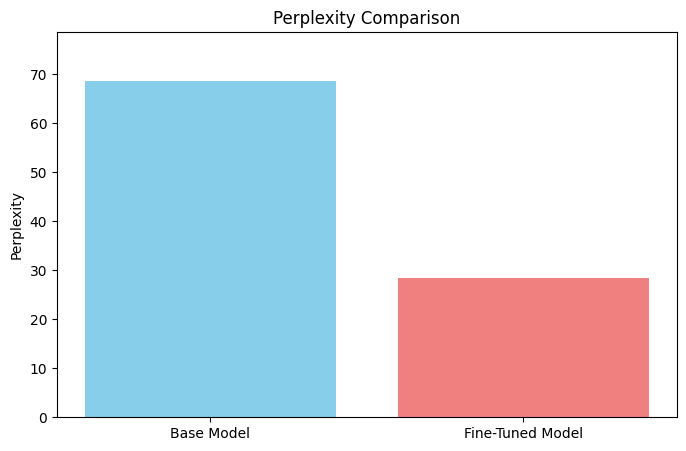

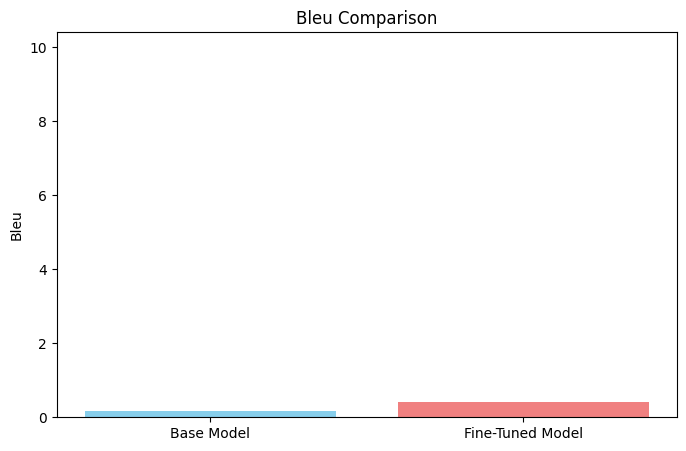

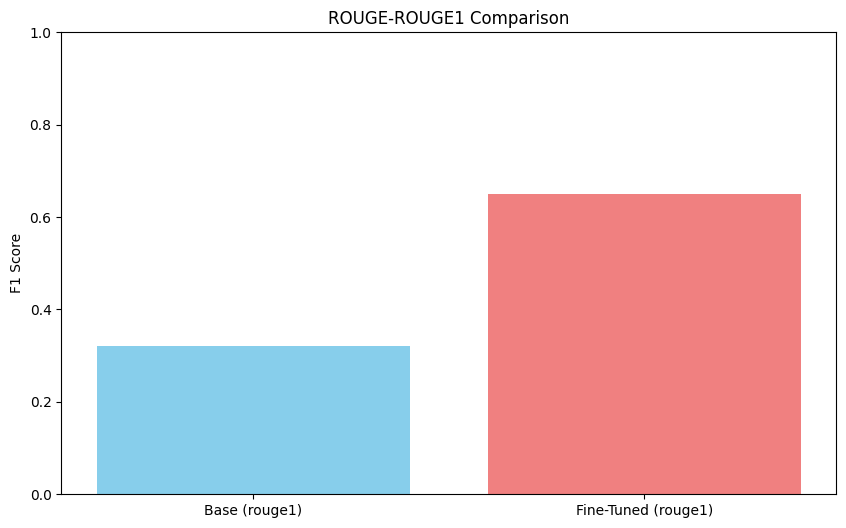

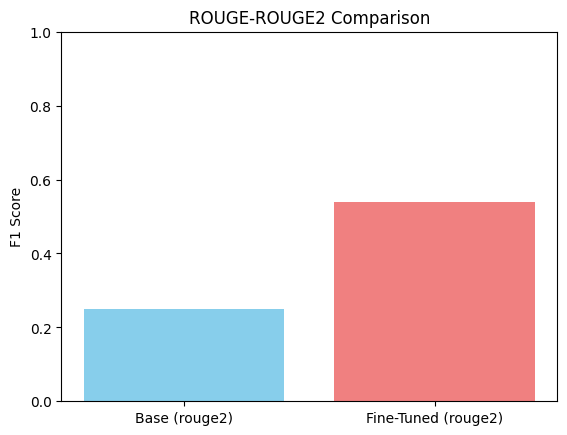

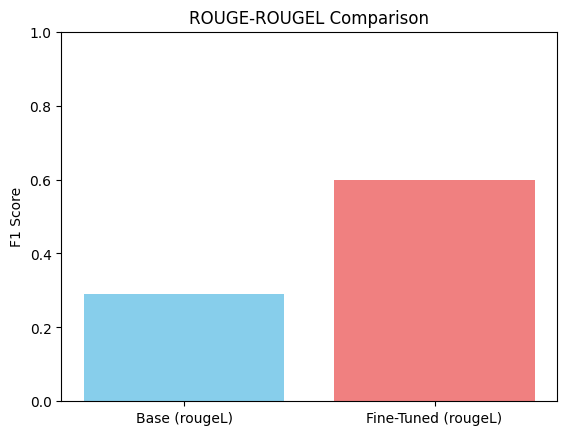

In [ ]:
# Plot comparison
evaluator.plot_comparison(results)

# Predictions

In [ ]:
def generate_story(model, tokenizer, max_length=128, genre="any"):

    messages = [
      {"role": "user", "content": f"Generate a Hindi story in genre: {genre}. Include various characters and animals (where necessary) with unique names."},
    ]

    input_ids = tokenizer.apply_chat_template(
      messages,
      add_generation_prompt=True,
      return_tensors="pt"
    ).to("cuda")

    outputs = model.generate(
      input_ids,
      max_new_tokens=max_length,
      eos_token_id=tokenizer.convert_tokens_to_ids("<|eot_id|>"),
      do_sample=True,
      temperature=0.6,
      top_p=0.9,
    )
    response = outputs[0][input_ids.shape[-1]:]
    return tokenizer.decode(response, skip_special_tokens=True)

In [8]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import GenerationConfig, TextStreamer , TextIteratorStreamer

model = AutoModelForCausalLM.from_pretrained("meta-llama/Meta-Llama-3.2-3B-Instruct", torch_dtype=torch.bfloat16).to("cuda")
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3.2-3B-Instruct", trust_remote_code=True)

story = generate_story(model, tokenizer, max_length = 1024, genre="Supernatural")
print(story)

**Ek Aatmrahat Ka Kahani** (A Story of Self-Discovery)

Ek chhota sa gaon tha, jismein ek chhote se jangal ke beech mein ek chhota sa ghar tha. Us ghar mein ek ladki thi, jiska naam **Kavita** tha. Vah ek aisa ladki tha, jo jangal ke raaz ko jaanta tha. Vah jangal ke jeevon ke saath bahut hi achha baat kar sakta tha.

Ek din, Kavita ne ek bada jangal ke jeev ko dekha, jiska naam **Rohan** tha. Rohan ek aisa jeev tha, jo jangal ke raaz ko jaanta tha. Vah Kavita se bahut hi achha baat karne laga.

Rohan ne Kavita ko ek aisa tareeka sikhaa, jisse vah jangal ke raaz ko samajh sakegi. Vah usse ek aisa tareeka bhi sikhaa, jisse vah jangal ke jeevon ko apne saath baitha sakegi.

Ek raat, Kavita ne ek aisa jeev dekha, jiska naam **Raju** tha. Raju ek aisa jeev tha, jo jangal ke jeevon ko apne saath baitha sakta tha. Vah Kavita se bahut hi achha baat karne laga.

Raju ne Kavita ko ek aisa tareeka sikhaa, jisse vah jangal ke jeevon ko apne saath baitha sakegi. Vah usse ek aisa tareeka bhi sikhaa

In [9]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import GenerationConfig, TextStreamer , TextIteratorStreamer

model = AutoModelForCausalLM.from_pretrained("DevChopra/KathaVachak-Llama-3.2-3B", torch_dtype=torch.bfloat16).to("cuda")
tokenizer = AutoTokenizer.from_pretrained("DevChopra/KathaVachak-Llama-3.2-3B", trust_remote_code=True)

story = generate_story(model, tokenizer, max_length = 1024, genre="Supernatural")
print(story)


      एक छोटे से गांव में, जहां झरने बहते थे और हरी-भरी पहाड़ियाँ थीं, एक छोटी लड़की रहती थी जिसका नाम नीला था। नीला बहुत ही जिज्ञासु और शरारती थी, और उसे हमेशा ही अजीबो-गरीब चीजों में दिलचस्पी होती थी। एक दिन, नीला अपने घर के पास के जंगल में खेल रही थी, जब उसने एक छोटी सी, चमकदार चीज को चमकते देखा। वह एक छोटा सा, चमकता हुआ पत्थर था जो पेड़ों की जड़ों के बीच पड़ा था। नीला उस पत्थर को उठाकर अपने हाथ में ले गई। जैसे ही उसने उसे छुआ, पत्थर ने एक तेज़ रोशनी निकाली, और नीला एक अजीबोगरीब जगह में पहुँच गई। 

यह जगह बहुत ही अजीब थी। चारों तरफ हरे-भरे पेड़ थे, लेकिन उन पेड़ों की पत्तियाँ चमक रही थीं जैसे हीरे। नीला ने कभी ऐसा नहीं देखा था। उसने अपने आस-पास देखा, तो उसे एक छोटा सा, गुलाबी रंग का जानवर दिखाई दिया। जानवर के शरीर पर चमकदार पंख थे और उसकी आँखें बहुत ही चमकदार नीली थीं।  

“नमस्ते,” नीला ने जानवर से कहा। “तुम कौन हो?”

“मेरा नाम फायरफ्लाई है,” जानवर ने कहा। “मैं एक छोटा सा, जादुई प्राणी हूँ जो इस चमकदार जंगल में रहता हूँ।”

नीला हैरान थी। “यह जगह कितनी खूबसूरत है!” उसने कहा। “मुझे ल